In [1]:
import sys
import pandas as pd
sys.path.append('../src')
from utils.image_padding import padd_mean_picture
from utils.data import select_tomo_ids

In [2]:
# padd_mean_picture('../data/pictures_process/mean_image', '../data/pictures_process/mean_image_padded', size = 960)

In [3]:
# padd_mean_picture('../data/pictures_process/adaptequal_1', '../data/pictures_process/adaptequal_1_padded', size = 960)
# padd_mean_picture('../data/pictures_process/adaptequal_01', '../data/pictures_process/adaptequal_01_padded', size = 960)
# padd_mean_picture('../data/pictures_process/adaptequal_05', '../data/pictures_process/adaptequal_05_padded', size = 960)

In [4]:
df = pd.read_csv('../data/csv_raw/train_labels.csv')
df.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
718,718,439,tomo_9a7701,229.0,237.0,794.0,500,924,956,19.7,6
486,486,326,tomo_6d22d1,50.0,797.0,362.0,300,960,928,13.1,1
160,160,21,tomo_066095,-1.0,-1.0,-1.0,300,960,928,15.6,0


In [5]:
all_slices_number = df['Array_shape_axis_0'].unique()
list(all_slices_number)

[500, 800, 600, 300, 400, 494]

In [6]:
from ml_logic.preprocess import selection_images_labels, batches_images_ram, read_img_jpg

2025-06-05 14:18:39.729829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 14:18:40.295553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-05 14:18:40.295595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-05 14:18:40.384992: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 14:18:43.138650: W tensorflow/stream_executor/platform/de

In [7]:
filtered_image_paths,labels = selection_images_labels(df, 'adaptequal_1_padded', num_slices=list(all_slices_number), num_motors=[1])

Found 648 images in ../data/pictures_process/adaptequal_1_padded
Matched 313 image-label pairs


In [8]:
train_ds, val_ds, test_ds = batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=True,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42)

2025-06-05 14:18:46.475487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-05 14:18:46.476073: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-05 14:18:46.476108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ADMINIS-I3M0BV4): /proc/driver/nvidia/version does not exist
2025-06-05 14:18:46.480113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


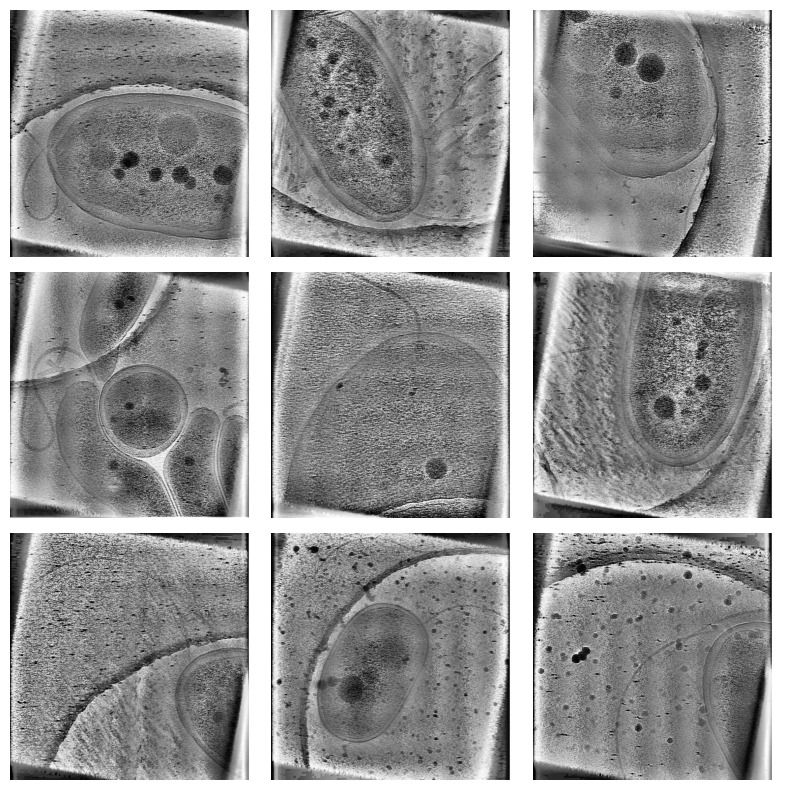

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take one batch (e.g., 32 images)
for batch in train_ds.take(1):
    images, _ = batch  # just images
    break

# Plot first 9 images in a 3x3 grid
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = tf.squeeze(images[i])
    plt.imshow(img.numpy(),cmap='gray')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
from keras import Sequential, Input, layers

def initiate_model():

    model = Sequential()
     ### First Convolution & MaxPooling
    model.add(Input(shape=(960, 960, 1)))
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (4,4), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))

    ## Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10,activation='relu'))

    model.add(layers.Dense(2,activation='linear'))

    return model

In [11]:
import tensorflow as tf

def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_pred - y_true, axis=1))

def compile_model(model):
    ### Model compilation
    model.compile(loss=euclidean_loss,optimizer='adam',metrics=[euclidean_loss], run_eagerly=True)
    return model

In [12]:
for images, labels in val_ds.take(1):
    print(images.shape, images.dtype)
    print(labels.shape, labels.dtype)

(32, 960, 960, 1) <dtype: 'float32'>
(32, 2) <dtype: 'float32'>


In [13]:
from ml_logic.interface import train
model = initiate_model()
model = compile_model(model)
model.summary()


Loading TensorFlow...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 960, 960, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 320, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 106, 106, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 719104)            0         
                                                                 
 dense (Dense)               (Non

In [19]:
train(model,
        train_ds,
        val_ds,
        model_type='pos2D',
        preprocess_type='adaptequal 1 - all slices number - padded',
        model_name='pos2d adaptequal1',
        batch_size = 32,
        patience = 1
    )


Loading TensorFlow...

🏋️ Starting model training ...

Training model...
Epoch 1/100
6/6 [==============================] - 175s 29s/step - loss: 290.1180 - euclidean_loss: 290.0915 - val_loss: 266.3876 - val_euclidean_loss: 266.3098
Epoch 2/100
6/6 [==============================] - 175s 29s/step - loss: 265.0172 - euclidean_loss: 265.3510 - val_loss: 245.8694 - val_euclidean_loss: 246.1606
Epoch 3/100
6/6 [==============================] - 168s 28s/step - loss: 260.4556 - euclidean_loss: 260.6612 - val_loss: 241.4517 - val_euclidean_loss: 241.6232
Epoch 4/100
6/6 [==============================] - 186s 32s/step - loss: 258.3978 - euclidean_loss: 258.1165 - val_loss: 226.6861 - val_euclidean_loss: 226.4203
Epoch 5/100
6/6 [==============================] - 166s 28s/step - loss: 249.9205 - euclidean_loss: 249.8668 - val_loss: 245.6696 - val_euclidean_loss: 245.2146
Epoch 5: early stopping
1/1 [==============================] - 1s 927ms/step


INFO:tensorflow:Assets written to: /tmp/tmpi80nogzc/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpi80nogzc/model/data/model/assets
2025/06/05 15:00:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpi80nogzc/model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.
2025/06/05 15:00:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


✅ Model trained with min val euclidean loss: 226.42


KeyError: 'val_mse'

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)
history.history

2025-06-05 14:18:51.458150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2025-06-05 14:18:55.090989: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2025-06-05 14:18:56.777508: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2025-06-05 14:19:09.989239: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2025-06-05 14:19:12.560727: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.


6/6 [==============================] - 149s 24s/step - loss: 498.4829 - euclidean_loss: 495.8403 - val_loss: 352.0945 - val_euclidean_loss: 353.0742


In [16]:
from transformers import TFViTModel
from tensorflow.keras import layers, Model
import tensorflow as tf

backbone = TFViTModel.from_pretrained("google/vit-base-patch16-224")
backbone.trainable = False
num_keypoints = 1

inputs = tf.keras.Input(shape=(960, 960, 1))
x = layers.Resizing(224, 224)(inputs)
features = backbone(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(num_keypoints * 2, activation="linear")(x)

model = Model(inputs, outputs)

/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.poo

ValueError: Exception encountered when calling layer "tf_vi_t_model" (type TFViTModel).

in user code:

    File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/models/vit/modeling_tf_vit.py", line 765, in call  *
        outputs = self.vit(
    File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filesz2o9eft.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/tmp/__autograph_generated_file4dgx91i1.py", line 24, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file0ks7syqa.py", line 12, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filezc3zfd8v.py", line 63, in tf__call
        projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)

    ValueError: Exception encountered when calling layer "vit" "                 f"(type TFViTMainLayer).
    
    in user code:
    
        File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/models/vit/modeling_tf_vit.py", line 595, in call  *
            embedding_output = self.embeddings(
        File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file0ks7syqa.py", line 12, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "/tmp/__autograph_generated_filezc3zfd8v.py", line 63, in tf__call
            projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
    
        ValueError: Exception encountered when calling layer "embeddings" "                 f"(type TFViTEmbeddings).
        
        in user code:
        
            File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/models/vit/modeling_tf_vit.py", line 129, in call  *
                embeddings = self.patch_embeddings(
            File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_filezc3zfd8v.py", line 63, in tf__call
                projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
        
            ValueError: Exception encountered when calling layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings).
            
            in user code:
            
                File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/transformers/models/vit/modeling_tf_vit.py", line 204, in call  *
                    projection = self.projection(pixel_values)
                File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/home/thomas/.pyenv/versions/3.10.6/envs/test_req2/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
                    raise ValueError(
            
                ValueError: Input 0 of layer "projection" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 1, 224)
            
            
            Call arguments received by layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
              • interpolate_pos_encoding=None
              • training=False
        
        
        Call arguments received by layer "embeddings" "                 f"(type TFViTEmbeddings):
          • pixel_values=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
          • interpolate_pos_encoding=None
          • training=False
    
    
    Call arguments received by layer "vit" "                 f"(type TFViTMainLayer):
      • self=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
      • pixel_values=None
      • head_mask=None
      • output_attentions=False
      • output_hidden_states=False
      • interpolate_pos_encoding=None
      • return_dict=True
      • training=False


Call arguments received by layer "tf_vi_t_model" (type TFViTModel):
  • self=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
  • pixel_values=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False